# Analisis Sentimen IMDb dengan RoBERTa-base (Fine-tuning)

In [ ]:
# Install libraries
!pip install transformers datasets evaluate scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.0 MB/s eta 0:00:00


## 1. Load Dataset IMDb

In [ ]:
from datasets import load_dataset

# Dataset IMDb
dataset = load_dataset("stanfordnlp/imdb")
dataset

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

## 2. Load Tokenizer dan Model RoBERTa-base

In [ ]:
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification

tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 3. Tokenisasi Dataset

In [ ]:
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=512)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

## 4. Membuat Data Collator

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## 5. Evaluasi: Akurasi

In [ ]:
!pip install evaluate
from evaluate import load
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

accuracy = load("accuracy")
f1 = load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy.compute(predictions=predictions, references=labels)
    return {
        'accuracy': acc['accuracy'],
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

## 6. Setup Trainer

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_dir="./logs",
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"].shuffle(seed=42).select(range(500)),
    eval_dataset=tokenized_datasets["test"].select(range(5000)),
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

## 7. Fine-tuning Model

In [ ]:
trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.158464,0.931200,0.000000
2,No log,0.935378,0.801600,0.000000
3,No log,0.304767,0.941400,0.000000
4,No log,0.503668,0.900800,0.000000


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


TrainOutput(global_step=252, training_loss=0.28974139501178076, metrics={'train_runtime': 774.4411, 'train_samples_per_second': 2.583, 'train_steps_per_second': 0.325, 'total_flos': 526222110720000.0, 'train_loss': 0.28974139501178076, 'epoch': 4.0})

## 8. Evaluasi Model

In [ ]:
trainer.evaluate()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'eval_loss': 0.5036680698394775,
 'eval_accuracy': 0.9008,
 'eval_f1': 0.0,
 'eval_runtime': 136.4499,
 'eval_samples_per_second': 36.643,
 'eval_steps_per_second': 4.58,
 'epoch': 4.0}

## 9. Simpan Model

In [ ]:
model.save_pretrained("./roberta-imdb")
tokenizer.save_pretrained("./roberta-imdb")

('./roberta-imdb/tokenizer_config.json',
 './roberta-imdb/special_tokens_map.json',
 './roberta-imdb/vocab.json',
 './roberta-imdb/merges.txt',
 './roberta-imdb/added_tokens.json',
 './roberta-imdb/tokenizer.json')

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


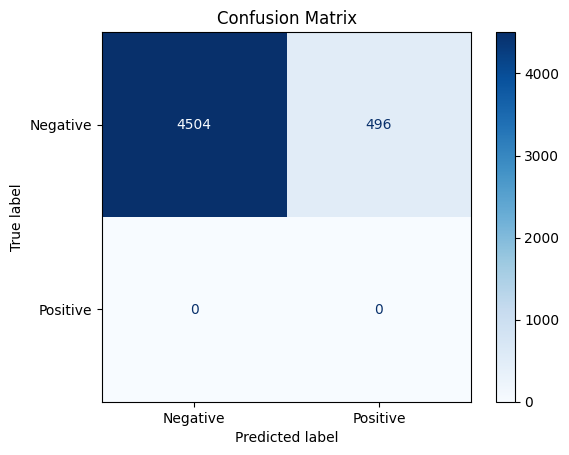

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions on the evaluation set
predictions = trainer.predict(tokenized_datasets["test"].select(range(5000)))
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Create a confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


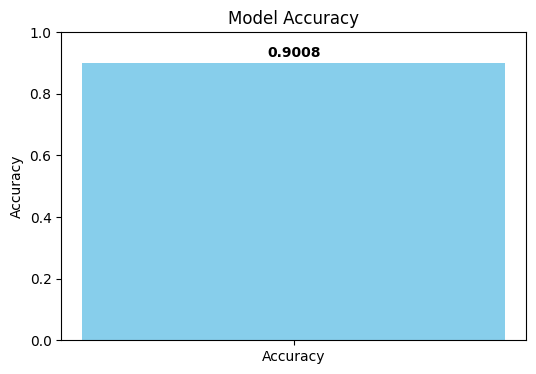

In [ ]:
# Get the evaluation accuracy
eval_results = trainer.evaluate()
accuracy_score = eval_results['eval_accuracy']

# Create a bar chart for accuracy
plt.figure(figsize=(6, 4))
plt.bar(['Accuracy'], [accuracy_score], color=['skyblue'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
for i, v in enumerate([accuracy_score]):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center', fontweight='bold')
plt.show()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


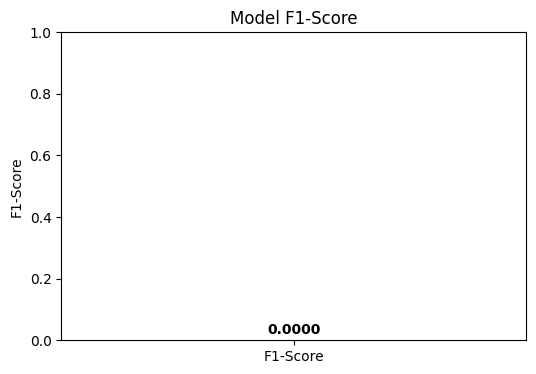

In [ ]:
from sklearn.metrics import f1_score

# Get predictions on the evaluation set
predictions = trainer.predict(tokenized_datasets["test"].select(range(5000)))
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels)

# Create a bar chart for F1-score
plt.figure(figsize=(6, 4))
plt.bar(['F1-Score'], [f1], color=['lightgreen'])
plt.ylim(0, 1)
plt.ylabel('F1-Score')
plt.title('Model F1-Score')
for i, v in enumerate([f1]):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center', fontweight='bold')
plt.show()

In [ ]:
import pandas as pd

# IMPORTANT: Please re-run the cell that defines `compute_metrics` and the cell
# that initializes the `Trainer` before running this cell.

# Run evaluation
eval_results = trainer.evaluate()

# Create a DataFrame from the evaluation results
df_results = pd.DataFrame([eval_results])

# Columns to display
columns_to_display = {
    'eval_accuracy': 'Accuracy',
    'eval_f1': 'F1-Score',
    'eval_precision': 'Precision',
    'eval_recall': 'Recall'
}

# Filter to only columns that exist in the results
existing_columns = {k: v for k, v in columns_to_display.items() if k in df_results.columns}

df_display = df_results[list(existing_columns.keys())]
df_display.rename(columns=existing_columns, inplace=True)


display(df_display)

/tmp/ipython-input-1436541997.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_display.rename(columns=existing_columns, inplace=True)


,Accuracy,F1-Score
0,0.9008,0.0


from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_0.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Accuracy']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Accuracy'}, axis=1)
              .sort_values('Accuracy', ascending=True))
  xs = counted['Accuracy']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_1.sort_values('Accuracy', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Accuracy')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['F1-Score']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'F1-Score'}, axis=1)
              .sort_values('F1-Score', ascending=True))
  xs = counted['F1-Score']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_2.sort_values('F1-Score', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('F1-Score')
_ = plt.ylabel('count()')